# Visualisation de données de trafic

In [1]:
import geopandas as gpd
%matplotlib inline
import xml.etree.cElementTree as et
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine
import os

## Geting started with a Python Notebook

* Edit Python cells
* Write documentation
* Embed graphics


## Getting started with Pandas

* create a dataframe `df = pd.DataFrame(columns = ['start_lon', 'start_lat'])`
* sample `df.head()` or `df.tail()`
* shape `df.shape()`
* plot `df.plot()`
* infos `df.infos()`
* filter mask `df_filtered = df[df["traffic_state"] == "V"]`
* size `df.size()`

More on pandas

* [Cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

## Plotting data on a map

* Using shapes [GeoPandas](http://geopandas.org/reference.html)
* Regular segments

## Référentiel des tronçons du Grand Lyon

Sous forme de Shapefile (`pvo_patrimoine_voirie.pvotronconwebcriter.shp`)
référentiel (sous forme de Shapefile) des points de mesures du Grand Lyon (`pvo_patrimoine_voirie.pvocomptagecriter.shp`)

In [2]:
# load shape files
sf = gpd.GeoDataFrame.from_file('data'+os.path.sep+'pvo_patrimoine_voirie.pvotronconwebcriter.dbf',encoding = 'gb18030')

In [3]:
# sample
sf.head()

,libelle,code,twgid,zoom,sens,fournisseu,idfourniss,longueur,gid,infotrafic,regulateur,calculateu,nombrevoie,geometry
0,AV CHARLES DE GAULLE,LYO01112,1112,2,1,CRITER,None,580,1,1,1,1,1.0,LINESTRING (4.774650383814889 45.7582534888056...
1,AV MARECHAL FOCH,LYO01128,1128,2,2,CRITER,None,1048,2,1,1,1,1.0,LINESTRING (4.797787280144347 45.7412701721376...
2,R CHATELAIN,LYO01132,1132,2,2,CRITER,None,307,3,0,1,1,1.0,LINESTRING (4.799451343876713 45.7353961239225...
3,RTE DE BRUISSIN,LYO01158,1158,2,1,CRITER RD,None,1677,4,0,1,1,NaN,LINESTRING (4.761906804324677 45.7372205476494...
4,AV DE LA TABLE DE PIERRE,LYO01166,1166,2,1,CRITER RD,None,1232,5,0,1,1,NaN,LINESTRING (4.76543968646797 45.75077204686175...


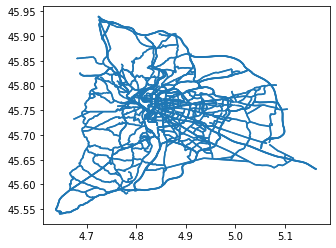

In [4]:
# plot geometry
sf.plot()

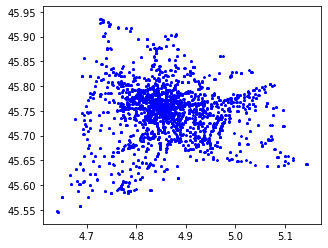

In [42]:
sf.representative_point().plot(marker='*', color='blue', markersize=5)
plt.show();

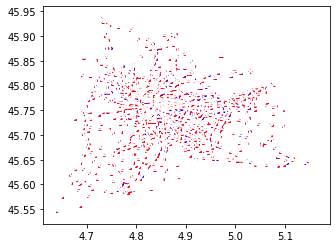

In [37]:
# compare sens


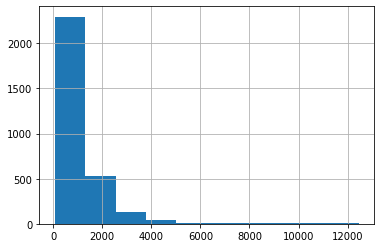

## Questions

* Afficher les les plus longues (histogrammes `.hist()` et filtrage)
* Comparer le sens des rues

## Alternative to geometry representation

In [44]:
# convert geometry to points
def linestring_to_points(feature,line):
    return {feature:list(line.coords)}

sf['points'] = sf.apply(lambda row: linestring_to_points(row['code'],row['geometry']),axis=1)

In [45]:
# sample points
sf.points.head()

0    {'LYO01112': [(4.7746503838148895, 45.75825348...
1    {'LYO01128': [(4.797787280144347, 45.741270172...
2    {'LYO01132': [(4.799451343876713, 45.735396123...
3    {'LYO01158': [(4.761906804324677, 45.737220547...
4    {'LYO01166': [(4.76543968646797, 45.7507720468...
Name: points, dtype: object

In [46]:
index_list = []
for i in range(len(sf)):
    for j in range(len(sf.points[i][sf.code[i]]) - 1):
        index_list_seg = [sf.points[i][sf.code[i]][j][0],sf.points[i][sf.code[i]][j][1],
                          sf.points[i][sf.code[i]][j+1][0], sf.points[i][sf.code[i]][j+1][1],
                         sf.code[i]]
        index_list.append(index_list_seg)

In [47]:
df = pd.DataFrame(columns = ['start_lon', 'start_lat', 'end_lon', 'end_lat', 'code'])

In [48]:
df['start_lon'] = list(i[0] for i in index_list)
df['start_lat'] = list(i[1] for i in index_list)
df['end_lon'] = list(i[2] for i in index_list)
df['end_lat'] = list(i[3] for i in index_list)
df['code'] = list(i[4] for i in index_list)

In [49]:
df.head()

,start_lon,start_lat,end_lon,end_lat,code
0,4.774650,45.758253,4.769970,45.754195,LYO01112
1,4.797787,45.741270,4.797814,45.742911,LYO01128
2,4.797814,45.742911,4.798819,45.744965,LYO01128
3,4.798819,45.744965,4.799089,45.746100,LYO01128
4,4.799089,45.746100,4.799103,45.746562,LYO01128


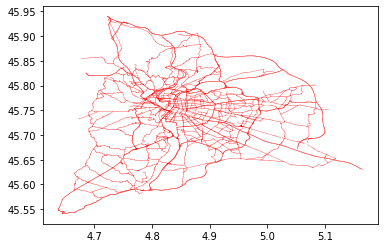

In [50]:
# same chart as above but using lines
plt.figure('asdf')
aa = plt.gca()
aa.plot([df.start_lon, df.end_lon], [df.start_lat, df.end_lat], color='r', linewidth=0.3, alpha=0.5)
plt.show(aa)

In [ ]:
df.head()

## Questions

* Why using geometry or line?

## Traffic data sources

Télécharger les données depuis [le site open data du Grand Lyon](https://data.grandlyon.com/jeux-de-donnees/etat-trafic-temps-reel-metropole-lyon/donnees)

Une section `<troncon_web_infotrafic>` par tronçon avec:

*  l'id du tronçon dans la balise `<id>` qui te permet de faire le lien avec la description géographique du tronçon associé dans le Shapefile sur l'attribut "twgid" du Shapefile
* l'état de trafic (traficolor) du tronçon dans la balise `<etat>`: `N` pour bloqué, `R` pour Rouge (saturé), `O` pour Orange (pré-saturé), `V` pour vert (fluide), `G` pour Gris (inconnu), `*` si pas de point de mesure) une ou plusieurs sections <point_de_mesure> par point(s) de mesure associé(s) au tronçon

 -  l'id du point de mesure dans la balise `<id_ptm>` qui te permet de faire le lien avec la description géographique du point de mesure associé dans le Shapefile sur l'attribut "identifian" du Shapefile
-  le débit 1minute du point de mesure dans la balise `<debit> (en nb de véhicules/heure)
-  le taux d'occupation 1 minute du point de mesure dans la balise `<taux>` (en %)
-  le débit 6minutes du point de mesure dans la balise `<debit_6min>` (en nb de véhicules/heure)
-  le taux d'occupation 6 minutes du point de mesure dans la balise `<taux_6min>` (en %)


Traffic_state (categorical): 
* `N` for congestion
* `R` for mild congestion
* `O` for smooth
* `V` for very smooth
* `G` unknown
* `\*` for no measuring point;



In [52]:
tree = et.ElementTree(file='data'+os.path.sep+'Etat_Troncons_Web_InfoTrafic_2019_04_11_00h00.xml')
root = tree.getroot()

In [54]:
tree

*Sample nodes from the traffic data source file*
```
    <troncon_web_infotrafic>
        <id>2164</id>
        <code>LYO02164</code>
        <libelle>RD342</libelle>
        <sens>2</sens>
        <longueur>2583</longueur>
        <fournisseur>CRITER RD</fournisseur>
        <id_fournisseur></id_fournisseur>
        <etat>*</etat>
        <dateMaj>11/04/2019,00:00:50</dateMaj>
    </troncon_web_infotrafic>
    <troncon_web_infotrafic>
        <id>1082</id>
        <code>LYO01082</code>
        <libelle>ENTREE RD12/BUS _ JONCTION A7N/D301</libelle>
        <sens>2</sens>
        <longueur>870</longueur>
        <fournisseur>CORALY</fournisseur>
        <id_fournisseur>n2_dde0043</id_fournisseur>
        <etat>V</etat>
        <dateMaj>11/04/2019,00:00:50</dateMaj>
        <point_de_mesure>
            <id_ptm>2099</id_ptm>
            <libelle_ptm>Voie_A7_SaintFons_Paris_2</libelle_ptm>
            <debit>180</debit>
            <taux>0</taux>
            <debit_6min>380</debit_6min>
            <taux_6min>1</taux_6min>
            <nbMesureManquante_6mn>0</nbMesureManquante_6mn>
            <seuil_orange>20</seuil_orange>
            <seuil_rouge>30</seuil_rouge>
            <hd_mesure>11/04/2019,00:00:00</hd_mesure>
            <hd_mesure_6mn>10/04/2019,23:54:00</hd_mesure_6mn>
        </point_de_mesure>
    </troncon_web_infotrafic>
```

In [55]:
def traffic_statement(x):
    if x in traffic_state.keys():
        return traffic_state[x]
    else:
        return None

In [60]:
# expected final dataset
df = pd.DataFrame(columns = ['start_lon', 'start_lat', 'end_lon', 'end_lat','code', 'time', 'hour', 'minute', # index values
                             'distance','traffic_state','longueur', 'debit', 'vitesse', 'taux', 'debit_6min', 
                             'taux_6min', 'nbMesureManquante_6mn', 'seuil_orange', 'seuil_rouge'])

h = 0 # hour
m = 0 # minute

file1 = 'data'+os.path.sep+"Etat_Troncons_Web_InfoTrafic_2019_04_11_00h00.xml"
#file1 = 'Etat_Troncons_Web_InfoTrafic_2019_04_11_' + x + y +'.xml'
tree = et.ElementTree(file = file1)
root = tree.getroot()

        
index_list = []
for i in range(len(sf)):
    for j in range(len(sf.points[i][sf.code[i]]) - 1):
        index_list_seg = [sf.points[i][sf.code[i]][j][0],sf.points[i][sf.code[i]][j][1],
                          sf.points[i][sf.code[i]][j+1][0], sf.points[i][sf.code[i]][j+1][1],
                         sf.code[i]]
        index_list.append(index_list_seg)
        
traffic_state = {}
for k in root.getchildren():
    if k.tag != 'entete':
        traffic_state[k.getchildren()[1].text] = k.getchildren()[7].text

#df = pd.DataFrame(columns = ['start_lon', 'start_lat', 'end_lon', 'end_lat', 'code'])

df['start_lon'] = list(i[0] for i in index_list)
df['start_lat'] = list(i[1] for i in index_list)
df['end_lon'] = list(i[2] for i in index_list)
df['end_lat'] = list(i[3] for i in index_list)
df['code'] = list(i[4] for i in index_list)
df['time'] = root.getchildren()[0].getchildren()[0].text
df['hour'] = h
df['minute'] = m


df['traffic_state']=df.apply(lambda row:traffic_statement(row['code']), axis=1)


#df_spie = pd.concat([df_spie, df], axis=0)
# print(m,n)

In [59]:
df.head()

,start_lon,start_lat,end_lon,end_lat,code,time,hour,minute,distance,traffic_state,longueur,debit,vitesse,taux,debit_6min,taux_6min,nbMesureManquante_6mn,seuil_orange,seuil_rouge
0,4.774650,45.758253,4.769970,45.754195,LYO01112,"11/04/2019,00:00:50",0,0,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.797787,45.741270,4.797814,45.742911,LYO01128,"11/04/2019,00:00:50",0,0,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.797814,45.742911,4.798819,45.744965,LYO01128,"11/04/2019,00:00:50",0,0,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.798819,45.744965,4.799089,45.746100,LYO01128,"11/04/2019,00:00:50",0,0,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.799089,45.746100,4.799103,45.746562,LYO01128,"11/04/2019,00:00:50",0,0,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


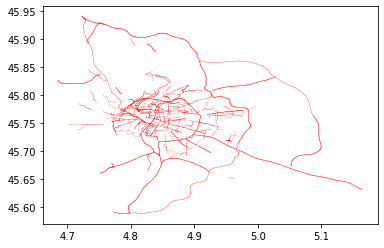

In [71]:
plt.figure('asdf')
aa = plt.gca()
aa.plot([df_filtered.start_lon, df_filtered.end_lon], [df_filtered.start_lat, df_filtered.end_lat], color='r', linewidth=0.3, alpha=0.5)
plt.show(aa)

In [ ]:
df.hist(column='hour')

## Questions

* En vous inspirant de `traffic_state` enrichissez le jeu de données (ex : enlevez les `NaN` avec d'autres attributs : `'distance','traffic_state','longueur', 'debit', 'vitesse', 'taux', 'debit_6min', 'taux_6min', 'nbMesureManquante_6mn', 'seuil_orange', 'seuil_rouge'`
* Générez des graphiques descriptifs des dimensions. (e.g. `plt.figure() df.hist()` ou `df["traffic_state"].hist()`)
* Quel est le plus long tronçon sur Lyon ? Affichez-le
* Quelles sont les valeurs maximales pour la longueur ? `.max()`
* Quelle est la longueur moyenne d'un tronçon ?

Remarques 

* Pensez bien à typer/nettoyer les données, e.g. `pd.to_numeric(df.longueur, errors='coerce').fillna(0)` (remplace les valeurs non-numériques par 0
* Créer un index si calcul sur valeurs temporelles cumulées

Bonus
* Combinez les données au fil des heures
* Afficher le [graphique cumulé](https://stackoverflow.com/questions/37293014/draw-a-cumulative-chart-from-a-pandas-dataframe) de trafic (total, par segments) 